## Capstone Project - Preserving Heritage: Enhancing Tourism with AI

**Problem Statement**

There are centuries old historical structures that preserve a country's and community's 
history for future generations and promote tourism opportunities. 

To improve tourism, a government agency decides to use advanced machine learning 
techniques to monitor the condition of these historical structures and report if any of 
them need maintenance. 

Also, understanding customers (tourists) and their expectations is critical for effective 
marketing and promotion of tourism. A recommendation engine is an excellent way to 
supplement existing marketing outreach. 

## Part 1

XYZ Pvt. Ltd., a leading industry consulting firm, has been hired to help the cause by 
developing an intelligent and automated AI model using TensorFlow that can predict the 
category of a structure in an image. 

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.19.0'

In [4]:
# Check if TensorFlow can access the GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs available:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPUs available.")

# List all available devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

No GPUs available.
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5696922260371945151
xla_global_id: -1
]


### 1.1 Load images

In [5]:
import os

# Use relative paths based on the notebook's location
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Go up one level from 'notebooks'
data_dir = os.path.join(base_dir, "data", "Part 1")

train_images_path = os.path.join(data_dir, "Stuctures_Dataset")
test_images_path = os.path.join(data_dir, "Dataset_test")

In [6]:
import os
import cv2
import matplotlib.pyplot as plt

# List all subfolders (categories)
categories = [d for d in os.listdir(train_images_path) if os.path.isdir(os.path.join(train_images_path, d))]

plt.figure(figsize=(15, 15))
for idx, category in enumerate(categories):
    category_path = os.path.join(train_images_path, category)
    # List all image files in the subfolder
    images = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if images:
        img_path = os.path.join(category_path, images[0])
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(categories), idx + 1)
        plt.imshow(img_rgb)
        plt.title(category)
        plt.axis('off')
plt.tight_layout()

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'c:\\Users\\filom\\OneDrive\\Documents\\Python Scripts\\Preserving Heritage and Enhancing Tourism with AI\\data\\Part 1\\Stuctures_Dataset'

In [ ]:
# Script to remove corrupted images
# This script will check each image in the dataset and remove any that are corrupted.
import os
from PIL import Image

def remove_corrupted_images(folder):
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(root, file)
                try:
                    img = Image.open(path)
                    img.verify()  # Verify that it is, in fact, an image
                except Exception as e:
                    print(f"Removing corrupted image: {path}")
                    os.remove(path)

remove_corrupted_images(train_images_path)
remove_corrupted_images(test_images_path)

In [ ]:
# Allow loading of truncated images in PIL
# This is useful if some images are partially corrupted but still contain some valid data.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True 

### 1.2 Select Transfer learning model

##### Callbacks

In [ ]:
# Early stopping callback to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
# Accuracy callback to monitor training progress

class MyEarlyStoppingCallback(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.90):
        super(MyEarlyStoppingCallback, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs.get('val_accuracy')
        if current_val_accuracy is None:
            print(f"\nWarning: 'val_accuracy' not found in logs for epoch {epoch+1}. Callback may not function as expected.")
            print(f"Available logs: {logs.keys()}")
            return
        
        print(f"\nEpoch {epoch+1}: Current Validation Accuracy = {current_val_accuracy:.4f}")
        if current_val_accuracy >= self.target_accuracy:
            print(f"\nTarget Validation Accuracy of {self.target_accuracy:.4f} reached at epoch {epoch+1}.")
            print("Training stopped.")
            self.model.stop_training = True

In [ ]:
#L learninrg rate scheduler to adjust the learning rate during training
from tensorflow.keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
    if epoch > 5:
        return lr * tf.math.exp(-0.1)
    return lr
lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
# Define the desired accuracy threshold for early stopping
desired_accuracy_threshold = 0.90 
my_stopper = MyEarlyStoppingCallback(target_accuracy=desired_accuracy_threshold)

# Combine the callbacks
callbacks = [early_stop, my_stopper, lr_scheduler]

##### VGG16

In [ ]:
# Image genrator for training data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Image generator for test data
# Using VGG16 preprocessing function for both training and test data
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

In [ ]:
# Pass images to the generator
train_generator = train_datagen.flow_from_directory(
    train_images_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_images_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 10235 images belonging to 10 classes.
Found 1475 images belonging to 10 classes.


In [ ]:
# VGG16 model
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the VGG16 model
for layer in vgg_model.layers:
    layer.trainable = False 

# Create a new model with the VGG16 base and custom top layers
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
x = vgg_model(input_layer)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
output_layer = tf.keras.layers.Dense(len(categories), activation='softmax')(x)

# Create the final model
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,694,154 (105.64 MB)

 Trainable params: 12,979,466 (49.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Compile the model
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [1]:
# Fit the model

hystory = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=3, #working on CPU, so using 3 epochs for quick testing
    verbose=1,
    callbacks=callbacks)

NameError: name 'model' is not defined

##### ResNet50

In [ ]:
# Images preprocessing generator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
trainImageData_rn50 = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    train_images_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
)

testImageData_rn50 = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    test_images_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)


In [ ]:
# Reuse ResNet50 architecture
from tensorflow.keras.applications import ResNet50
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the ResNet50 model
for layer in resnet_model.layers:
    layer.trainable = False
    
# Create a new model with the ResNet50 base and custom top layers   
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
x = resnet_model(input_layer)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
output_layer = tf.keras.layers.Dense(len(categories), activation='softmax')(x)

# Create the final model
model_resnet = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model_resnet.summary()

In [ ]:
# Compile the model
model_resnet.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
# Fit the model
history_restnet = model_resnet.fit(
    trainImageData_rn50,
    steps_per_epoch=trainImageData_rn50.samples // trainImageData_rn50.batch_size,
    validation_data=testImageData_rn50,
    validation_steps=testImageData_rn50.samples // testImageData_rn50.batch_size,
    epochs=3,  # working on CPU, so using 3 epochs for quick testing
    verbose=1,
    callbacks=callbacks
)

##### InceptionV3

In [ ]:
# Images preprocessing generator for InceptionV3

trainImageData_inception = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
).flow_from_directory(
    train_images_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
)

testImageData_inception = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
).flow_from_directory(
    test_images_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

In [ ]:
# Reuse InceptionV3 architecture
model_inception = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the layers of the InceptionV3 model
for layer in model_inception.layers:
    layer.trainable = False 


In [ ]:
# Create a new model with the InceptionV3 base and custom top layers
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
x = model_inception(input_layer)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
output_layer = tf.keras.layers.Dense(len(categories), activation='softmax')(x)

# Create the final model
model_inception_final = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
# Summary of the model
model_inception_final.summary()

In [ ]:
# Compile the model
model_inception_final.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
# Fit the model
hystory_inception = model_inception_final.fit(
    trainImageData_inception,
    steps_per_epoch=trainImageData_inception.samples // trainImageData_inception.batch_size,
    validation_data=testImageData_inception,
    validation_steps=testImageData_inception.samples // testImageData_inception.batch_size,
    epochs=3,  # working on CPU, so using 3 epochs for quick testing
    verbose=1,
    callbacks=callbacks
)

##### Compare the Models

In [ ]:
# Compare results/performances of different Transfer Learning models

import matplotlib.pyplot as plt

def plot_history(histories, model_names):
    """
    Plots training and validation accuracy and loss for multiple models.
    Args:
        histories: List of Keras History objects.
        model_names: List of model names as strings.
    """
    plt.figure(figsize=(16, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{name} Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], linestyle='--', label=f'{name} Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_history([hystory, history_restnet, hystory_inception], ['VGG16', 'ResNet50', 'InceptionV3'])

All models are overfitted; however, despite VGG16 and RestNet50 increasing in accuracy throughout epochs, Inception V3 decreases in accuracy.
If we look at the loss, only RestNet50 has a decreasing loss.

For these reasons, I will choose RestNet50 as the model.

### 1.3 Fine-tuning the chosen model - RestNet50

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

x = resnet_model.output # Using ResNet50 as the final model for deployment

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)  # Adding dropout for regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)  # Adding dropout for regularization

output_layer = Dense(len(categories), activation='softmax')(x)

# Create the final model
final_model = tf.keras.models.Model(inputs=resnet_model.input, outputs=output_layer)

# Model summary
final_model.summary()

In [ ]:
# Compile the model
final_model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
# Fit the final model
final_history = final_model.fit(
    trainImageData_rn50,
    steps_per_epoch=trainImageData_rn50.samples // trainImageData_rn50.batch_size,
    validation_data=testImageData_rn50,
    validation_steps=testImageData_rn50.samples // testImageData_rn50.batch_size,
    epochs=5,  # working on CPU, so using 5 epochs for quick testing
    verbose=1,
    callbacks=callbacks
)

In [ ]:
# Print the latest values
max_acc = max(acc)
max_val_acc = max(val_acc)

# Print the highest values
print(f"Highest training accuracy: {max_acc:.4f}")
print(f"Highest validation accuracy: {max_val_acc:.4f}")

In [ ]:
# Save model
final_model.save(os.path.join(base_dir, "models", "CNN_final_model.h5"))

## Part 2

The second objective of this project requires you to perform exploratory data analysis 
and develop a recommendation engine that will help tourists visit their places of interest. 

### 2.1 Load datasets

In [ ]:
import os
# Define paths for the second part of the project
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Go up one level from 'notebooks'
data_dir = os.path.join(base_dir, "data", "Part 2")

users_path = os.path.join(data_dir, "user.csv")
actractions_path = os.path.join(data_dir, "tourism_with_id.xlsx")
ratings_path = os.path.join(data_dir, "tourism_rating.csv")

In [13]:
import pandas as pd

# Load the users data
users_df = pd.read_csv(users_path)

print("Users DataFrame:")
print(users_df.head())

# Load the attractions data
attractions_df = pd.read_excel(actractions_path)

print("\nAttractions DataFrame:")
print(attractions_df.head())

# Load the ratings data
ratings_df = pd.read_csv(ratings_path)

print("\nRatings DataFrame:")
print(ratings_df.head())

Users DataFrame:
   User_Id                   Location  Age
0        1      Semarang, Jawa Tengah   20
1        2         Bekasi, Jawa Barat   21
2        3        Cirebon, Jawa Barat   23
3        4         Bekasi, Jawa Barat   21
4        5  Lampung, Sumatera Selatan   20

Attractions DataFrame:
   Place_Id                         Place_Name  \
0         1                   Monumen Nasional   
1         2                           Kota Tua   
2         3                      Dunia Fantasi   
3         4  Taman Mini Indonesia Indah (TMII)   
4         5           Atlantis Water Adventure   

                                         Description       Category     City  \
0  Monumen Nasional atau yang populer disingkat d...         Budaya  Jakarta   
1  Kota tua di Jakarta, yang juga bernama Kota Tu...         Budaya  Jakarta   
2  Dunia Fantasi atau disebut juga Dufan adalah t...  Taman Hiburan  Jakarta   
3  Taman Mini Indonesia Indah merupakan suatu kaw...  Taman Hiburan  Jakarta   


In [14]:
# Check for missing values in the users DataFrame
missing_users = users_df.isnull().sum()
print("\nMissing values in Users DataFrame:")
print(missing_users[missing_users > 0])
# Check for missing values in the attractions DataFrame
missing_attractions = attractions_df.isnull().sum()
print("\nMissing values in Attractions DataFrame:")
print(missing_attractions[missing_attractions > 0])
# Check for missing values in the ratings DataFrame
missing_ratings = ratings_df.isnull().sum()
print("\nMissing values in Ratings DataFrame:")
print(missing_ratings[missing_ratings > 0])


Missing values in Users DataFrame:
Series([], dtype: int64)

Missing values in Attractions DataFrame:
Time_Minutes    232
Unnamed: 11     437
dtype: int64

Missing values in Ratings DataFrame:
Series([], dtype: int64)


We see that Attractions Dataframe hase missing values for Time_Minutes feature and a column unnamed to "Unnamed:11' to be removed

In [15]:
attractions_df.shape

(437, 13)

In [16]:
attractions_df['Unnamed: 11'].isnull().sum()  # Check for missing values in the 'Unnamed: 11' column

437

In [17]:
attractions_df.drop(columns=['Unnamed: 11'], inplace=True)  # Drop the 'Unnamed: 11' column

In [18]:
attractions_df.columns

Index(['Place_Id', 'Place_Name', 'Description', 'Category', 'City', 'Price',
       'Rating', 'Time_Minutes', 'Coordinate', 'Lat', 'Long', 'Unnamed: 12'],
      dtype='object')

In [19]:
attractions_df['Unnamed: 12'].tail(10)  # Check the last 10 values of the 'Unnamed: 12' column

427    428
428    429
429    430
430    431
431    432
432    433
433    434
434    435
435    436
436    437
Name: Unnamed: 12, dtype: int64

We can see that this column is actually an index column starting from 1, since we are using dataframe (indexed by 0) we can remove this column 

In [20]:
attractions_df.drop(columns=['Unnamed: 12'], inplace=True) 

In [21]:
attractions_df.columns.to_list()  # List all column names

['Place_Id',
 'Place_Name',
 'Description',
 'Category',
 'City',
 'Price',
 'Rating',
 'Time_Minutes',
 'Coordinate',
 'Lat',
 'Long']

In [22]:
# Replace Nan values in Time_Minutes column with mean of the column
attractions_df['Time_Minutes'].fillna(attractions_df['Time_Minutes'].mean(), inplace=True)


C:\Users\filom\AppData\Local\Temp\ipykernel_17964\4063782788.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  attractions_df['Time_Minutes'].fillna(attractions_df['Time_Minutes'].mean(), inplace=True)


In [23]:
attractions_df.isnull().sum()  # Check for any remaining missing values

Place_Id        0
Place_Name      0
Description     0
Category        0
City            0
Price           0
Rating          0
Time_Minutes    0
Coordinate      0
Lat             0
Long            0
dtype: int64

### 2.2 Data exploration

#### 2.2.1 Users

In [24]:
# Explore users DataFrame
users_df.info()  # Get information about the DataFrame
users_df.describe()  # Get descriptive statistics of the DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


,User_Id,Age
count,300.000000,300.000000
mean,150.500000,28.700000
std,86.746758,6.393716
min,1.000000,18.000000
25%,75.750000,24.000000
50%,150.500000,29.000000
75%,225.250000,34.000000
max,300.000000,40.000000


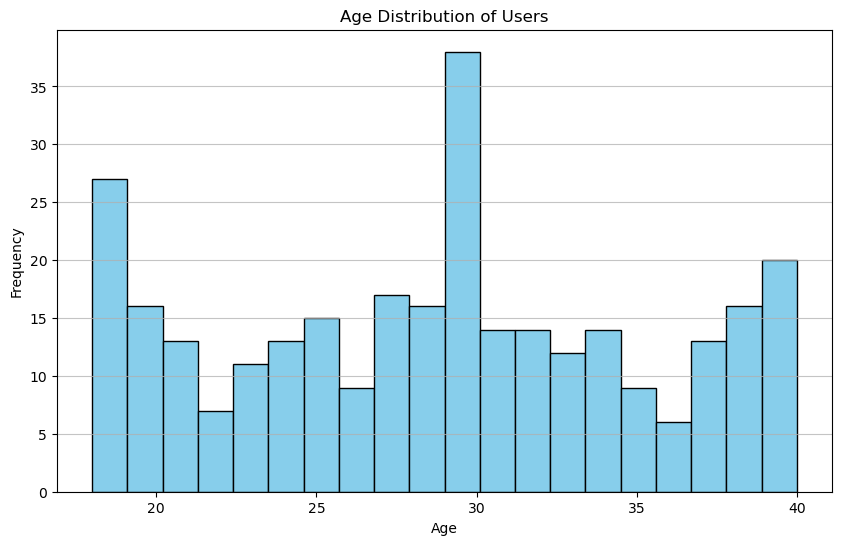

In [25]:
# Plot age distribution

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(users_df['Age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Age Distribution of Users')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


<Axes: xlabel='Age'>

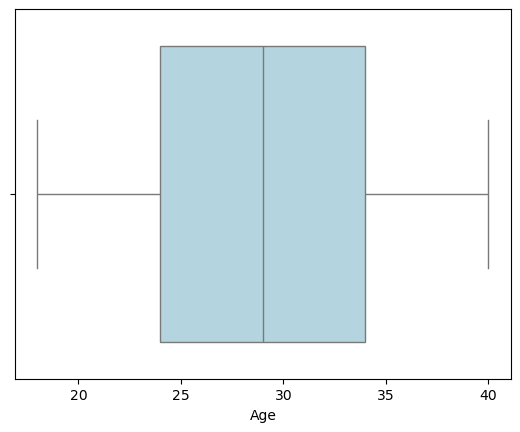

In [26]:
import seaborn as sns

sns.boxplot(x=users_df['Age'], color='lightblue')

We can see that there are no outliers and that the distribution is not normal, with a peak at 30 years old.

The describe function also showed that the youngest user is 18 years old and the oldest is 40 years old

C:\Users\filom\AppData\Local\Temp\ipykernel_17964\726801252.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations.index, y=top_locations.values, palette='viridis')


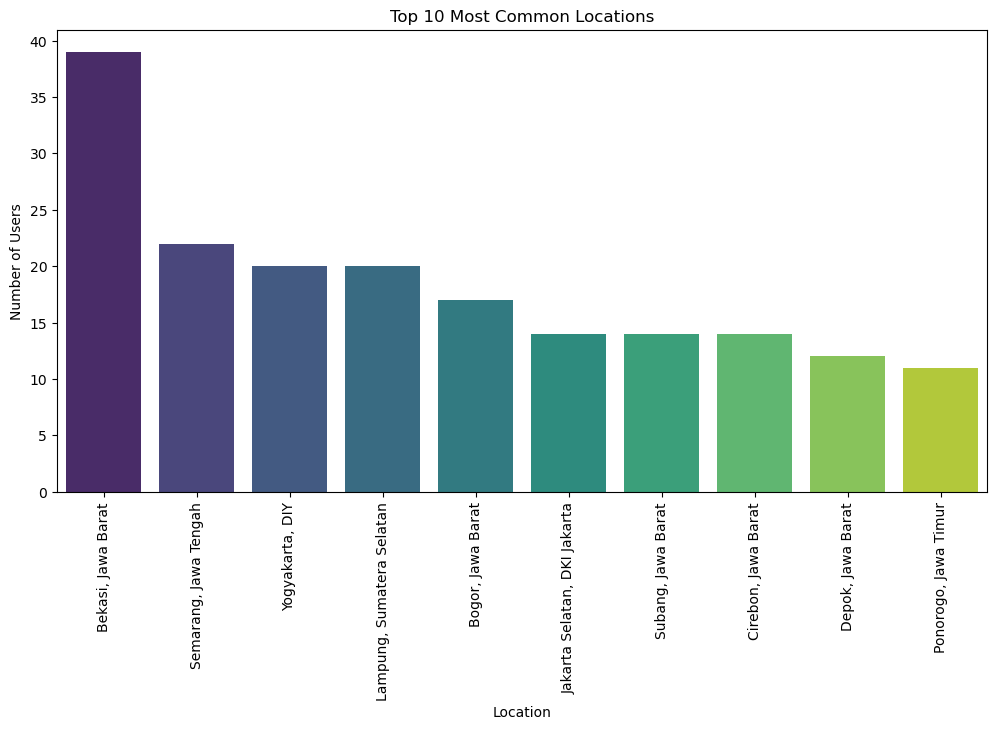

In [27]:
# Plot distribution of top 10 most common Locations
plt.figure(figsize=(12, 6))
top_locations = users_df['Location'].value_counts().head(10)
sns.barplot(x=top_locations.index, y=top_locations.values, palette='viridis')
plt.title('Top 10 Most Common Locations')
plt.xlabel('Location')
plt.ylabel('Number of Users')
plt.xticks(rotation=90)
plt.show()


#### 2.2.1 Locations and Categories 

In [28]:
attractions_df.info()  # Get information about the attractions DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  437 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
dtypes: float64(4), int64(2), object(5)
memory usage: 37.7+ KB


In [29]:
# List all unique categories in the attractions DataFrame
unique_categories = attractions_df['Category'].unique()
print("Unique Categories in Attractions DataFrame:")
for category in unique_categories:
    print(category, ) 
    

Unique Categories in Attractions DataFrame:
Budaya
Taman Hiburan
Cagar Alam
Bahari
Pusat Perbelanjaan
Tempat Ibadah


In [30]:
# List all unique cities in the attractions DataFrame

unique_categories = attractions_df['City'].unique()
print("Unique cities in Attractions DataFrame:")
for category in unique_categories:
    print(category) 

Unique cities in Attractions DataFrame:
Jakarta
Yogyakarta
Bandung
Semarang
Surabaya



Distinct Categories in Attractions DataFrame:
Budaya
Taman Hiburan
Cagar Alam
Bahari
Pusat Perbelanjaan
Tempat Ibadah


C:\Users\filom\AppData\Local\Temp\ipykernel_17964\2074634366.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_categories.index, x=top_categories.values, palette='viridis', orient='h')


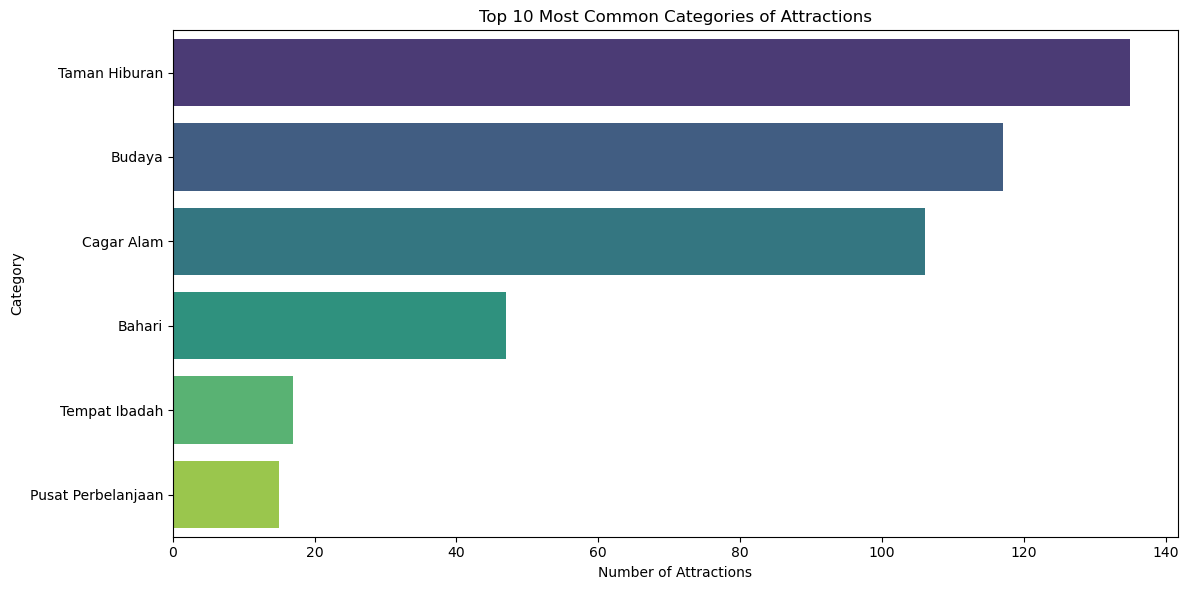

In [31]:
# Show the distinct Categories in the attractions DataFrame
distinct_categories = attractions_df['Category'].unique()
print("\nDistinct Categories in Attractions DataFrame:")
for category in distinct_categories:
    print(category)
# Plot distribution of top 10 most common Categories (horizontal barplot)
plt.figure(figsize=(12, 6))
top_categories = attractions_df['Category'].value_counts().head(10)
sns.barplot(y=top_categories.index, x=top_categories.values, palette='viridis', orient='h')
plt.title('Top 10 Most Common Categories of Attractions')
plt.ylabel('Category')
plt.xlabel('Number of Attractions')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [32]:
# Idetntify the best rated tourist attractions for each city
best_rated_attractions = attractions_df.loc[attractions_df.groupby('City')['Rating'].idxmax()]
print("\nBest Rated Attractions for Each City:")
print(best_rated_attractions[['City', 'Place_Name', 'Rating']])



Best Rated Attractions for Each City:
           City                          Place_Name  Rating
277     Bandung       Masjid Daarut Tauhiid Bandung     4.9
28      Jakarta           Wisata Kuliner Pecenongan     5.0
371    Semarang            Gua Maria Kerep Ambarawa     4.8
411    Surabaya            Masjid Nasional Al-Akbar     4.9
94   Yogyakarta  Desa Wisata Sungai Code Jogja Kota     5.0


In [33]:
# Identify the city with highest rated Plac_Name of category 'Cagar Alam' (nature enthusiat)
nature_enthusiast = attractions_df[attractions_df['Category'] == 'Cagar Alam']
highest_rated_nature = nature_enthusiast.loc[nature_enthusiast['Rating'].idxmax()]
print("\nHighest Rated Nature Enthusiast Attraction:")
print(f"City: {highest_rated_nature['City']}, Place Name: {highest_rated_nature['Place_Name']}, Rating: {highest_rated_nature['Rating']}")



Highest Rated Nature Enthusiast Attraction:
City: Bandung, Place Name: Kebun Tanaman Obat Sari Alam, Rating: 4.9


### 2.3 Combine data

In [34]:
ratings_df.columns.to_list()  # List all column names in the ratings DataFrame

['User_Id', 'Place_Id', 'Place_Ratings']

In [35]:
attractions_df.columns.to_list()  # List all column names in the attractions DataFrame

['Place_Id',
 'Place_Name',
 'Description',
 'Category',
 'City',
 'Price',
 'Rating',
 'Time_Minutes',
 'Coordinate',
 'Lat',
 'Long']

In [36]:
users_df.columns.to_list()  # List all column names in the users DataFrame

['User_Id', 'Location', 'Age']

In [37]:
# Combine the three DataFrames into a single DataFrame
combined_df = pd.merge(ratings_df, users_df, on='User_Id', how='left')
combined_df = pd.merge(combined_df, attractions_df, on='Place_Id', how='left')
# Display the first few rows of the combined DataFrame
print("\nCombined DataFrame:")
print(combined_df.head())


Combined DataFrame:
   User_Id  Place_Id  Place_Ratings               Location  Age  \
0        1       179              3  Semarang, Jawa Tengah   20   
1        1       344              2  Semarang, Jawa Tengah   20   
2        1         5              5  Semarang, Jawa Tengah   20   
3        1       373              3  Semarang, Jawa Tengah   20   
4        1       101              4  Semarang, Jawa Tengah   20   

                      Place_Name  \
0                Candi Ratu Boko   
1                  Pantai Marina   
2       Atlantis Water Adventure   
3         Museum Kereta Ambarawa   
4  Kampung Wisata Sosro Menduran   

                                         Description       Category  \
0  Situs Ratu Baka atau Candi Boko (Hanacaraka:Í¶...         Budaya   
1  Pantai Marina (bahasa Jawa: Í¶•Í¶±Í¶∂Í¶±Í¶∂Í¶Ç...         Bahari   
2  Atlantis Water Adventure atau dikenal dengan A...  Taman Hiburan   
3  Museum Kereta Api Ambarawa (bahasa Inggris: In...         Budaya   
4  K

In [38]:
# List most loved attactions by users and city with highest average rating
most_loved_attractions = combined_df.groupby(['City', 'Place_Name']).agg({'Rating': 'mean', 'User_Id': 'count'}).reset_index()
most_loved_attractions.columns = ['City', 'Place_Name', 'Average_Rating', 'Number_of_Reviews']
most_loved_attractions = most_loved_attractions.sort_values(by='Average_Rating', ascending=False)
print("\nMost Loved Attractions by Users:")
print(most_loved_attractions.head(10))

# Print the average rate by city
print("\nAverage Rating by City:")
print(most_loved_attractions.groupby('City')['Average_Rating'].mean().sort_values(ascending=False))

# Identify the city with the highest average rating
highest_avg_rating_city = most_loved_attractions.groupby('City')['Average_Rating'].mean().idxmax()
print(f"\nCity with Highest Average Rating: {highest_avg_rating_city}")
# Print the top 10 most loved attractions in the city with the highest average rating
top_attractions_city = most_loved_attractions[most_loved_attractions['City'] == highest_avg_rating_city].head(10)
print(f"\nTop 10 Most Loved Attractions in {highest_avg_rating_city}:")
print(top_attractions_city[['Place_Name', 'Average_Rating', 'Number_of_Reviews']])


Most Loved Attractions by Users:
           City                          Place_Name  Average_Rating  \
129     Jakarta                     Freedom Library             5.0   
336  Yogyakarta  Desa Wisata Sungai Code Jogja Kota             5.0   
362  Yogyakarta        Kauman Pakualaman Yogyakarta             5.0   
207     Jakarta           Wisata Kuliner Pecenongan             5.0   
48      Bandung        Kebun Tanaman Obat Sari Alam             4.9   
281    Surabaya            Masjid Nasional Al-Akbar             4.9   
57      Bandung       Masjid Daarut Tauhiid Bandung             4.9   
29      Bandung   Gereja Tiberias Indonesia Bandung             4.9   
180     Jakarta                       Pulau Pelangi             4.8   
60      Bandung                   Masjid Salman ITB             4.8   

     Number_of_Reviews  
129                 25  
336                 25  
362                 13  
207                 33  
48                  31  
281                 15  
57       

In [39]:
# Identify the average rating for each category
average_rating_by_category = combined_df.groupby('Category')['Rating'].mean().reset_index()
print("\nAverage Rating by Category:")
print(average_rating_by_category.sort_values(by='Rating', ascending=False))



Average Rating by Category:
             Category    Rating
5       Tempat Ibadah  4.715844
1              Budaya  4.523034
3  Pusat Perbelanjaan  4.457662
2          Cagar Alam  4.404058
4       Taman Hiburan  4.401965
0              Bahari  4.369694


### 2.4 Build reccomender model

Use the above data to develop a collaborative filtering model for recommendation and 
use that to recommend other places to visit using the current tourist location (place 
name)


In [40]:
# Will use surprise library for collaborative filtering
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD, accuracy
from surprise import KNNBasic

# Specify reader for the ratings data
reader = Reader(rating_scale=(1, 5))  # Assuming ratings are between 1 and 5

# Since we will do collaborative filering based on place wi will create a df merging ratings and attractions
ratings_attractions_df = pd.merge(ratings_df, attractions_df, on='Place_Id', how='left')

# Create a Surprise dataset from the DataFrame
data = Dataset.load_from_df(ratings_attractions_df[['User_Id', 'Place_Id', 'Rating']], reader)

# Split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Use KNN algorithm for collaborative filtering
knn_algo = KNNBasic(k=40, sim_options={'name': 'cosine', 'user_based': False}) # we will use item based since the reccomandation system will be based on the attractions and not on the users
knn_algo.fit(trainset)

# Make predictions on the test set
predictions = knn_algo.test(testset)
# Calculate and print the RMSE
rmse = accuracy.rmse(predictions)
print(f"RMSE of KNN Algorithm: {rmse:.4f}")



Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2172
RMSE of KNN Algorithm: 0.2172


In [ ]:
# Get the top n recommendations for a specific user based on his location
def get_top_n_recommendations_knn(place_name, df_attractions, algo, n=10):
    """
    Get the top n recommendations for a specific place based on collaborative filtering.
    
    Args:
        place_name (str): The name of the place to get recommendations for.
        df_attractions (DataFrame): DataFrame containing attractions data.
        algo (Surprise algorithm): The trained collaborative filtering algorithm.
        n (int): Number of recommendations to return.
        
    Returns:
        list: List of recommended attractions.
    """
    # Get the Place_Id for the given place_name
    place_id = df_attractions[df_attractions['Place_Name'].str.contains(place_name, case=False, na=False)]['Place_Id'].values[0]
    if not place_id:
        raise ValueError(f"Place '{place_name}' not found in the attractions data.")
    
    # Get all user ids
    user_ids = df_attractions['User_Id'].unique()
    
    # Create a list to hold predictions
    predictions = []
    
    # Predict ratings for all users for the given place_id
    for user_id in user_ids:
        pred = algo.predict(user_id, place_id)
        predictions.append((user_id, pred.est))
    
    # Sort predictions by estimated rating in descending order
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Get the top n recommendations
    top_n = predictions[:n]
    
    # Get the recommended attractions' names
    recommended_places = df_attractions[df_attractions['Place_Id'].isin([x[0] for x in top_n])]['Place_Name'].unique()
    
  
    return recommended_places.tolist()


In [46]:
ratings_attractions_df.head(20)

,User_Id,Place_Id,Place_Ratings,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,179,3,Candi Ratu Boko,Situs Ratu Baka atau Candi Boko (Hanacaraka:Í¶...,Budaya,Yogyakarta,75000,4.6,90.000000,"{'lat': -7.7705416, 'lng': 110.4894158}",-7.770542,110.489416
1,1,344,2,Pantai Marina,Pantai Marina (bahasa Jawa: Í¶•Í¶±Í¶∂Í¶±Í¶∂Í¶Ç...,Bahari,Semarang,3000,4.1,82.609756,"{'lat': -6.948877, 'lng': 110.3893285}",-6.948877,110.389329
2,1,5,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.000000,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134
3,1,373,3,Museum Kereta Ambarawa,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Budaya,Semarang,10000,4.5,60.000000,"{'lat': -7.264598899999997, 'lng': 110.4046017}",-7.264599,110.404602
4,1,101,4,Kampung Wisata Sosro Menduran,Kampung wisata Sosromenduran merupakan kampung...,Budaya,Yogyakarta,0,4.0,82.609756,"{'lat': -7.792189999999999, 'lng': 110.362151}",-7.792190,110.362151
5,1,312,2,Taman Hutan Raya Ir. H. Juanda,Taman Hutan Raya Ir. H. Djuanda (Tahura Djuand...,Cagar Alam,Bandung,11000,4.5,90.000000,"{'lat': -6.8585841, 'lng': 107.6306089}",-6.858584,107.630609
6,1,258,5,Museum Gedung Sate,Salah satu museum yang menjadi ikon kota ini a...,Budaya,Bandung,5000,4.6,82.609756,"{'lat': -6.902637899999999, 'lng': 107.619169}",-6.902638,107.619169
7,1,20,4,Museum Taman Prasasti,Museum Taman Prasasti adalah sebuah museum cag...,Budaya,Jakarta,2000,4.5,90.000000,"{'lat': -6.172224099999998, 'lng': 106.8189695}",-6.172224,106.818969
8,1,154,2,Pantai Ngrawe (Mesra),Kabupaten Gunungkidul jadi salah satu wilayah ...,Bahari,Yogyakarta,10000,4.5,82.609756,"{'lat': -8.1333389, 'lng': 110.5537405}",-8.133339,110.553741
9,1,393,5,Taman Harmoni Keputih,Tempat tersebut ialah Taman Hatmoni Keputih Su...,Cagar Alam,Surabaya,0,4.4,60.000000,"{'lat': -7.2952211, 'lng': 112.8035603}",-7.295221,112.803560


In [48]:
# Example usage
recommended_places = get_top_n_recommendations_knn("Jaka", ratings_attractions_df, knn_algo, n=5)

# reccomended places in Jakarta for user with id 1
print("Recommended Places in Jakarta:")
for place in recommended_places:
    print(place)



Recommended Places in Jakarta:
Alun-Alun Kota Bandung
Pantai Samas
Taman Balai Kota Bandung
Museum Kebangkitan Nasional
Museum Geologi Bandung


In [ ]:
# Save the trained KNN model
import pickle
knn_model_path = os.path.join(base_dir, "models", "knn_model.pkl")
with open(knn_model_path, 'wb') as f:
    pickle.dump(knn_algo, f)